# Steganalysis ROC/AUC Curves

This document contains some tools to generate ROC/AUC curves, and then generates several curves for our suite of Steganalysis tools, on a sample encoded image bank.

## Set-up

### Modules

In [73]:
!pip install scikit-plot 

### Collecting Data

#### SteganoGAN

In [4]:
!git clone https://github.com/jnickg/steganet

Cloning into 'steganet'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 35 (delta 9), reused 10 (delta 1), pack-reused 0
Unpacking objects: 100% (35/35), done.


### Installing StegExpose

In [1]:
# Install the Java JDK.
!apt-get install default-jdk > /dev/null

# Check the Java version to see if everything is working well.
!javac -version

!git clone https://github.com/b3dk7/StegExpose

javac 11.0.11
Cloning into 'StegExpose'...
remote: Enumerating objects: 314, done.
remote: Total 314 (delta 0), reused 0 (delta 0), pack-reused 314
Receiving objects: 100% (314/314), 38.31 MiB | 36.43 MiB/s, done.
Resolving deltas: 100% (133/133), done.


## Statistical Steganalysis

We use `StegExpose` to evaluate our encoded images using a suite of statistical attacks.

Save the results to `stegexpose_analysis`, so we can later extract results from the many tools it encompasses.

Specifically, we'll look at:
* Chi Square Attack (Westfeld, 1999)
* RS Analysis (Fridrich, 2001)
* Primary Sets (Dumitrescu, 2002)

### SteganoGAN Encodings

In [23]:
!java -jar ./StegExpose/StegExpose.jar /content/steganet/assets/test_images/ default default steg_expose.csv

In [29]:
!awk '!/^$/' steg_expose.csv > steg_expose_clean.csv
stegexpose_results_file = 'steg_expose_clean.csv'

#### Overall Results

In [30]:
from prettytable import from_csv

with open(stegexpose_results_file) as fp:
  stegexpose_analysis = from_csv(fp)
  print(stegexpose_analysis)

+------------------+------------------------+-------------------------------------------------------+-----------------------+----------------------+---------------------+----------------------+-----------------------+
|    File name     | Above stego threshold? | Secret message size in bytes (ignore for clean files) |      Primary Sets     |      Chi Square      |     Sample Pairs    |     RS analysis      |     Fusion (mean)     |
+------------------+------------------------+-------------------------------------------------------+-----------------------+----------------------+---------------------+----------------------+-----------------------+
|  input (1).png   |         false          |                         27014                         | 0.0027757271722806953 | 8.820295629479369E-4 | 0.00931381861772712 | 0.009866536838759855 | 0.0057095280479289015 |
| Dense_output.png |         false          |                         404960                        |          NaN          | 0.

#### Loading to Memory

Rather than just dumping the data to a pretty table, let's now load it into a 2-D "tensor" of results, where the first axis is the input file name, and the second axis is the attack vector. Elements are $[0.0,1.0]$ probabilities based on that attack.

In [66]:
import csv
import numpy as np
with open(stegexpose_results_file) as fp:
  stegexpose_results = []
  stegexpose_files = []
  stegexpose_actuals = []
  stegexpose_reader = csv.reader(fp)
  next(stegexpose_reader) # skip header
  for row in stegexpose_reader:
    if len(row) > 0:
      stegexpose_files.append(row[0])
      stegexpose_results.append(row[3:])
      label = 1 # assume it was encoded unless it's an input image
      if ('input' in row[0]):
        label = 0
      stegexpose_actuals.append(label)


stegexpose_files = np.array(stegexpose_files)
stegexpose_results = np.array(stegexpose_results)
stegexpose_actuals = np.array(stegexpose_actuals)

In [67]:
print(stegexpose_files)

['input (1).png' 'Dense_output.png' 'Basic_output.png']


In [68]:
print(stegexpose_results)

[['0.0027757271722806953' '8.820295629479369E-4' '0.00931381861772712'
  '0.009866536838759855' '0.0057095280479289015']
 ['NaN' '0.002974292221644861' '0.07730278219798781'
  '0.07567560042732396' '0.051984224948985545']
 ['0.02950287639129132' '0.009233439993378239' '0.03330575897854599'
  '0.029716130698238086' '0.02543955151536341']]


In [69]:
print(stegexpose_actuals)

[0 1 1]


#### Extracting a single set of results

These values represent probabilities based on the given attack, that 

In [63]:
primary_sets_idx = 0
chi_square_idx = 1
sample_pairs_idx = 2
rs_analysis_idx = 3
fusion_idx = 4

In [92]:
def extract_column(csv_data, idx):
  results = np.array([float(r) for r in csv_data[:,idx]])
  return results

chi_square_results = extract_column(stegexpose_results, chi_square_idx)
print(chi_square_results)

[0.00088203 0.00297429 0.00923344]


### ROC Curves

Based on the results of our statistical steganalysis, which contains probability values, we now increase our threshold and plot ROC data.

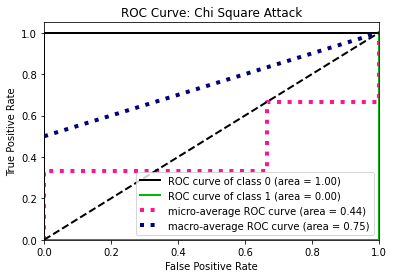

In [98]:
from sklearn import metrics
import scikitplot as skplt
import matplotlib.pyplot as plt

def print_roc_for(actual_labels, predictions, name):
  probs = np.reshape(np.concatenate((1.0-actual_labels,actual_labels)), (-1, 2))
  skplt.metrics.plot_roc(stegexpose_actuals, chi_square_probs)
  plt.title(f'ROC Curve: {name}')
  plt.show()

print_roc_for(stegexpose_actuals, chi_square_results, "Chi Square Attack")

Now that we are able to generate a single ROC curve, let's put it together and generate curves for all of our attack vectors, based on the steganalysis resutls!

In [104]:
indices = [primary_sets_idx, chi_square_idx, sample_pairs_idx, rs_analysis_idx, fusion_idx]
names = ['Primary Sets Attack', 'Chi Square Attack', 'Sample Pairs Attack', ' RS Analysis', 'StegExpose Fusion']

# Expects results to be a 2D array where the first axis is the image that was
# predicted, and the second axis represents the attack vector. Anyone wanting to
# print using this, for a single attack vector, should have a size-one array for
# prediction_indices and prediction_names, and results should be a 2D array with
# a single column (one set of attack-vector results for many different images)
def print_all_rocs(results, actuals, prediction_indices, prediction_names):
  for (name, idx) in zip(names, indices):
    col = extract_column(results, idx)
    print_roc_for(actuals, col, name)

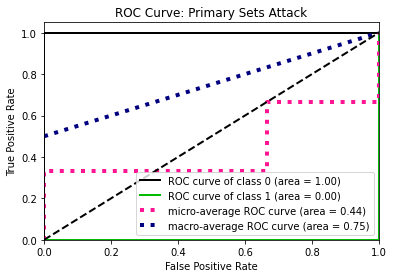

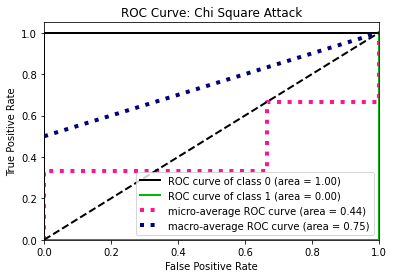

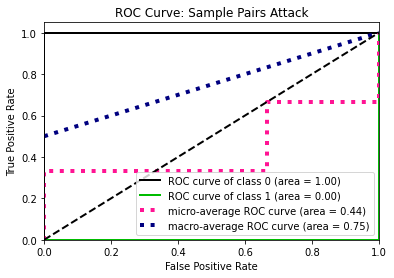

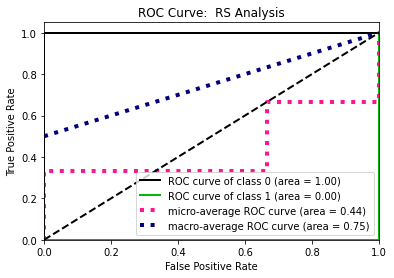

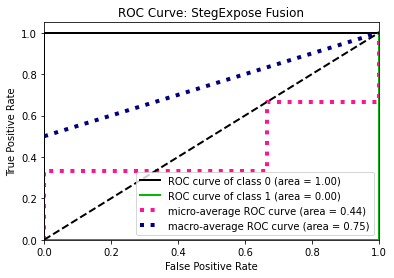

In [105]:
print_all_rocs(stegexpose_results, stegexpose_actuals, indices, names)